In [366]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk import ngrams
from wordcloud import WordCloud
import warnings

# Suppress the printing of UserWarning messages
warnings.filterwarnings('ignore', category=UserWarning)



In [367]:
pd.set_option("max_colwidth", 270)
db= pd.read_parquet(r'dbLista.parquet')

In [368]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45459 entries, 0 to 45458
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    45459 non-null  int32         
 1   title                 45459 non-null  string        
 2   genres                45459 non-null  string        
 3   overview              45459 non-null  string        
 4   tagline               45459 non-null  string        
 5   spoken_languages      45459 non-null  string        
 6   original_language     45459 non-null  string        
 7   budget                45459 non-null  int64         
 8   revenue               45459 non-null  float64       
 9   popularity            45459 non-null  float64       
 10  release_date          45459 non-null  datetime64[ns]
 11  runtime               45459 non-null  float64       
 12  production_companies  45459 non-null  string        
 13  production_count

Eliminamos duplicados y texto en otros alfabetos


In [369]:
db=db.drop_duplicates(subset=['overview', 'title'])
db = db.dropna(subset=['genres'])


In [371]:
def is_cjk_arabic_hebrew_russian_polish(s):
    return bool(re.search(r'[\u4E00-\u9FFF\u3040-\u30FF\u0600-\u06FF\u0590-\u05FF\u0400-\u04FF\u0100-\u017F]', s))
# Drop rows where the 'title' column contains Chinese, Japanese, Arabic, Hebrew, Russian or Polish characters
db = db[~db['overview'].apply(is_cjk_arabic_hebrew_russian_polish)]
db = db[~db['title'].apply(is_cjk_arabic_hebrew_russian_polish)]

Eliminamos las películas que no tengan reseña

In [374]:
db = db[db['overview'] != '*Unavailable']


In [375]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44290 entries, 0 to 45458
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    44290 non-null  int32         
 1   title                 44290 non-null  string        
 2   genres                44290 non-null  string        
 3   overview              44290 non-null  string        
 4   tagline               44290 non-null  string        
 5   spoken_languages      44290 non-null  string        
 6   original_language     44290 non-null  string        
 7   budget                44290 non-null  int64         
 8   revenue               44290 non-null  float64       
 9   popularity            44290 non-null  float64       
 10  release_date          44290 non-null  datetime64[ns]
 11  runtime               44290 non-null  float64       
 12  production_companies  44290 non-null  string        
 13  production_count

In [376]:
db.describe()

,id,budget,revenue,popularity,runtime,vote_average,vote_count,release_year,return
count,44290.000000,4.429000e+04,4.429000e+04,44290.000000,44290.000000,44290.000000,44290.000000,44290.000000,4.429000e+04
mean,106924.625401,4.325654e+06,1.149088e+07,2.979908,94.977128,5.638474,112.514541,1991.784105,6.762259e+02
std,111857.295871,1.763338e+07,6.514366e+07,6.070160,37.536189,1.895863,497.467656,24.155829,7.560344e+04
min,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1874.000000,0.000000e+00
25%,25896.500000,0.000000e+00,0.000000e+00,0.405253,85.000000,5.000000,3.000000,1978.000000,0.000000e+00
50%,58468.500000,0.000000e+00,0.000000e+00,1.163596,95.000000,6.000000,10.000000,2001.000000,0.000000e+00
75%,153213.500000,0.000000e+00,0.000000e+00,3.826002,107.000000,6.800000,35.000000,2010.000000,0.000000e+00
max,469172.000000,3.800000e+08,2.787965e+09,547.488298,1256.000000,10.000000,14075.000000,2020.000000,1.239638e+07


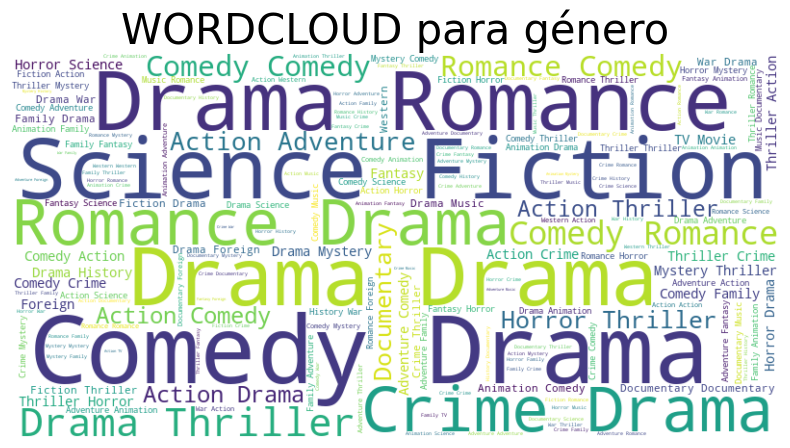

In [377]:
# Create a word cloud image
text =  ' '.join(db['genres'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('WORDCLOUD para género',fontsize=30)
plt.axis('off')
plt.show()
%matplotlib inline

Vemos que usando los generos de las películas como variable no es muy bueno ya que hay palabras como Drama, Comedia o Romance que claramente dominan sobre las demás. Esto genera que los clusters no esten bien definidos luego del modelado. En el siguiente histograma lo podemos ver claramente:

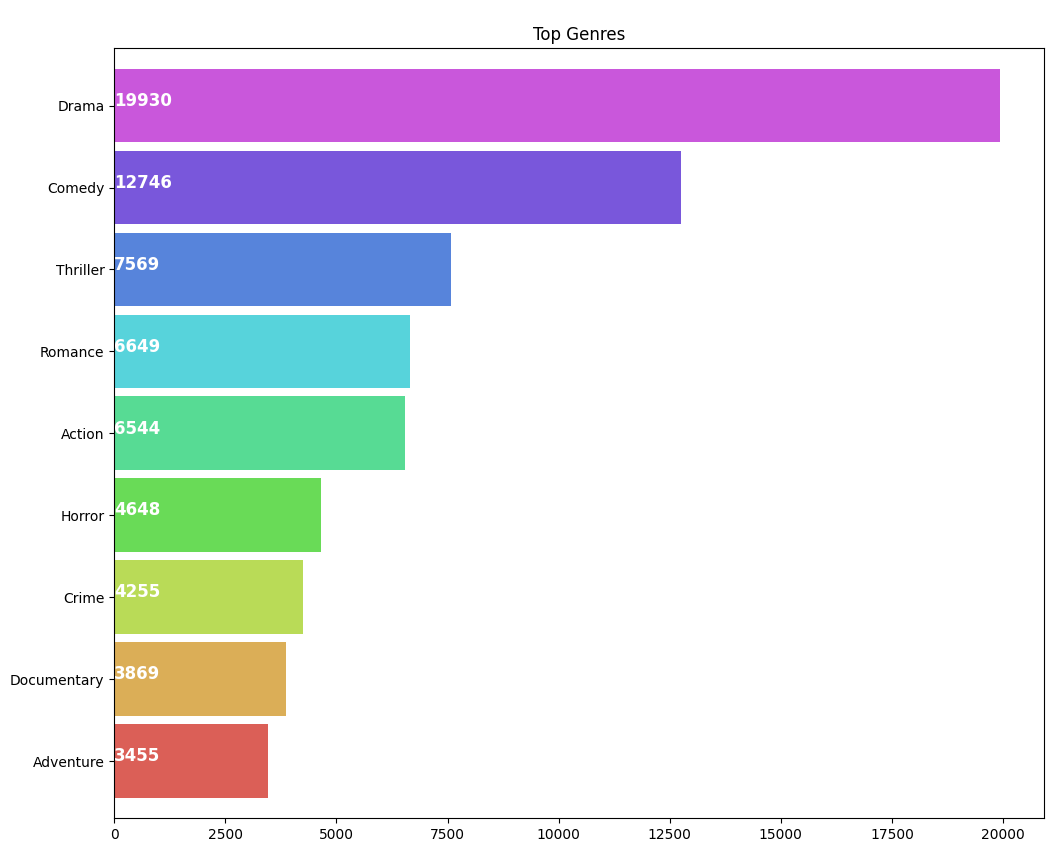

In [378]:

plt.subplots(figsize=(12,10))

db['genres'] = db['genres'].apply(lambda x: x if x.strip() else None)
db = db.dropna(subset=['genres'])

db['genres'] = db['genres'].str.strip('[]').str.strip().str.replace("'",'').str.replace("   ",' ')

db['genres'] = db['genres'].str.split(" ")


list1 = []
for i in db['genres']:
    
    list1.extend(i)
ax = pd.Series(list1).value_counts()[1:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Genres')
plt.show()

Usando Títulos mas Reseña (overview) la nube de palabras mejora bastante. Lamentablemente la poca capacidad de Render hace que no sea posible utilizar Reseña para la recomendación, así que usarekos Género, sabiendo de antemano que los resultados no seran optimos

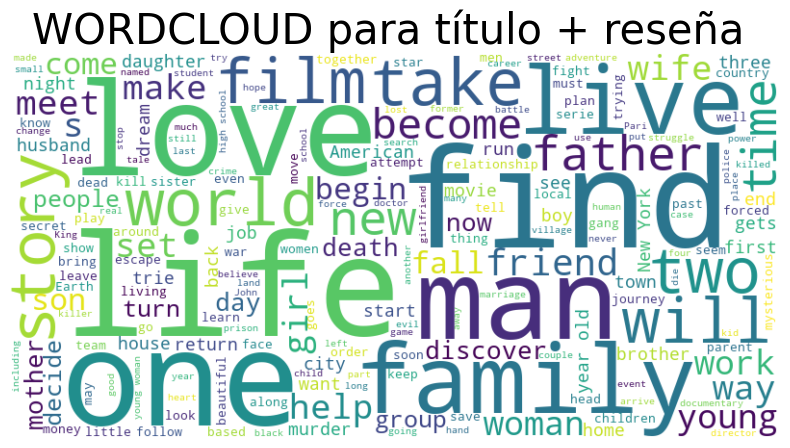

In [379]:

# Create a word cloud image
text = ' '.join(db['title']) + ' '.join(db['overview'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('WORDCLOUD para título + reseña ',fontsize=30)
plt.axis('off')
plt.show()
%matplotlib inline

Análisis estadístico de la columna **Popularidad** 

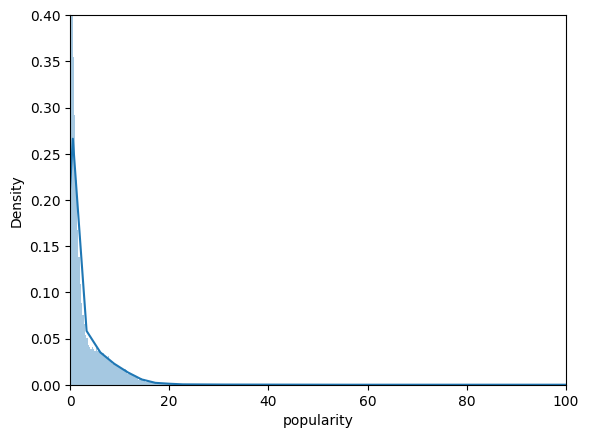

In [380]:
ax = sns.distplot(db['popularity'], bins=2000)
ax.set_xlim(0, 100)
ax.set_ylim(0, 0.4)

# Show the plot
plt.show()

Decidimos tomar los valores de popularidad entre 0,5 (hay muchas películas con popularidad 0) y 10, ya que durante el ETL notamos que valores mayores corresponden a outliers.

In [381]:
db = db[(db['popularity'] <= 10) & (db['popularity'] >= 0.5) ]

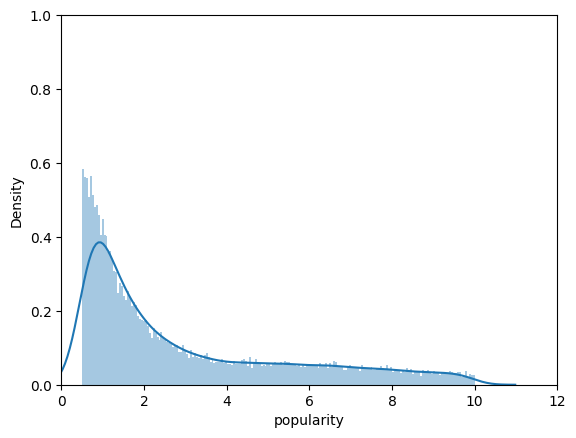

In [382]:
ax = sns.distplot(db['popularity'], bins=200)
ax.set_xlim(0, 12)
ax.set_ylim(0, 1)

# Show the plot
plt.show()


Mean: 2.9629300544426953
Median: 1.8479965
Lower Quartile: 0.98676075
Upper Quartile: 4.45675175
Minimum: 0.5
Maximum: 9.998415


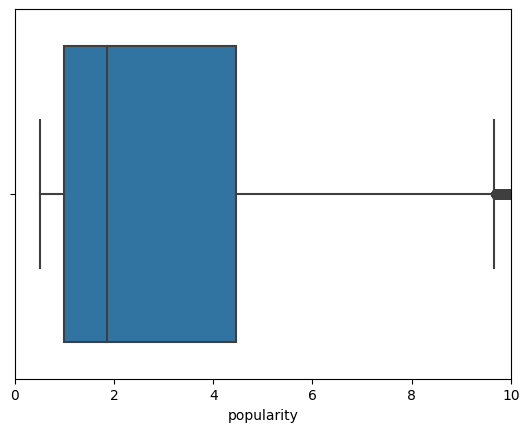

In [383]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Create a boxplot using Seaborn
ax = sns.boxplot(x='popularity', data=db)
ax.set_xlim(0, 10)

# Get the statistical values
statistics = db['popularity']

# Extract required statistical values
mean = np.mean(statistics)
median = np.median(statistics)
lower_quartile = np.percentile(statistics, 25)
upper_quartile = np.percentile(statistics, 75)
minimum = np.min(statistics)
maximum = np.max(statistics)

# Print the statistical values
print("Mean:", mean)
print("Median:", median)
print("Lower Quartile:", lower_quartile)
print("Upper Quartile:", upper_quartile)
print("Minimum:", minimum)
print("Maximum:", maximum)

# Show the plot
plt.show()

In [384]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27956 entries, 3 to 45456
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    27956 non-null  int32         
 1   title                 27956 non-null  string        
 2   genres                27956 non-null  object        
 3   overview              27956 non-null  string        
 4   tagline               27956 non-null  string        
 5   spoken_languages      27956 non-null  string        
 6   original_language     27956 non-null  string        
 7   budget                27956 non-null  int64         
 8   revenue               27956 non-null  float64       
 9   popularity            27956 non-null  float64       
 10  release_date          27956 non-null  datetime64[ns]
 11  runtime               27956 non-null  float64       
 12  production_companies  27956 non-null  string        
 13  production_count

Guardamos este dataset para que luego sea consumido por la Api

In [48]:
db.to_parquet('dbFinal.parquet')